In [1]:
from string import punctuation
import os
from os import listdir
from collections import Counter
from nltk.corpus import stopwords
from numpy import array
from numpy import asarray
from numpy import zeros

# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# turn a doc into clean tokens
def clean_doc(doc):
	# split into tokens by white space
	tokens = doc.split()
	# remove punctuation from each token
	table = str.maketrans('', '', punctuation)
	tokens = [w.translate(table) for w in tokens]
	# remove remaining tokens that are not alphabetic
	tokens = [word for word in tokens if word.isalpha()]
	# filter out stop words
	stop_words = set(stopwords.words('english'))
	tokens = [w for w in tokens if not w in stop_words]
	# filter out short tokens
	tokens = [word for word in tokens if len(word) > 1]
	return tokens

# load doc and add to vocab
def add_doc_to_vocab(filename, vocab):
	# load doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# update counts
	vocab.update(tokens)

# load all docs in a directory
def process_docs_1(directory, vocab):
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip files that do not have the right extension
		if not filename.endswith(".txt"):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# add doc to vocab
		add_doc_to_vocab(path, vocab)
# load all docs in a directory
def process_docs_2(directory, vocab):
	lines = list()
	# walk through all files in the folder
	for filename in listdir(directory):
		# skip files that do not have the right extension
		if not filename.endswith(".txt"):
			continue
		# create the full path of the file to open
		path = directory + '/' + filename
		# load and clean the doc
		line = doc_to_line(path, vocab)
		# add to list
		lines.append(line)
	return lines
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
	# load the doc
	doc = load_doc(filename)
	# clean doc
	tokens = clean_doc(doc)
	# filter by vocab
	tokens = [w for w in tokens if w in vocab]
	return ' '.join(tokens)


# save list to file
def save_list(lines, filename):
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()


# load vocabulary
vocab_filename = 'aclImdb/imdb.vocab'
vocab = load_doc(vocab_filename)
vocab = vocab.split()
vocab = set(vocab)
positive_docs = process_docs_2('aclImdb/train/pos', vocab)
negative_docs = process_docs_2('aclImdb/train/neg', vocab)
train_docs = negative_docs + positive_docs
print(len(vocab))
doc_size = len(positive_docs)
print(doc_size)
print(len(train_docs))

89527
12500
25000


In [2]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, SpatialDropout1D, Input
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D
from keras.layers.convolutional import Conv1D
from keras.utils.vis_utils import plot_model
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#logo tou provlhmatos me to cudnn
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)  # set this TensorFlow session as the default session for Keras

# training
epochs = 10
# Convolution
kernel_size = 5
filters = 300
pool_size = 5
# vector
n_dim = 128 
n_unique_words = 20000
max_review_length = 200
pad_type = trunc_type = 'pre'
# LSTM
n_lstm = 256 
drop_lstm = 0.2

# create the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_docs)
encoded_docs = tokenizer.texts_to_sequences(train_docs)
print(len(encoded_docs))

Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device

25000


In [3]:
x_train = pad_sequences(encoded_docs, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [4]:
print(len(x_train))

25000


In [5]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [6]:
# create a weight matrix for words in training docs
vocab_size = len(vocab)
embedding_matrix = zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [7]:
print(len(embedding_matrix))

89527


In [8]:
y_train = np.array([0 for _ in range(doc_size)] + [1 for _ in range(doc_size)])
print(len(y_train))

25000


In [9]:
# load all test reviews
positive_docs = process_docs_2('aclImdb/test/pos', vocab)
negative_docs = process_docs_2('aclImdb/test/neg', vocab)
test_docs = negative_docs + positive_docs
encoded_docs = tokenizer.texts_to_sequences(test_docs)
x_valid = pad_sequences(encoded_docs, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
y_valid = np.array([0 for _ in range(doc_size)] + [1 for _ in range(doc_size)])
print(len(x_valid))
print(len(y_valid))

25000
25000


In [10]:
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], trainable=False)
model.add(e)
model.add(SpatialDropout1D(0.2))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(5))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(MaxPooling1D(5))
model.add(LSTM(256))
model.add(Dense(1, activation='sigmoid'))









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [11]:
model.summary()
#plot_model(model, show_shapes=True, to_file='glove_cnnstacked_lstm.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         26858100  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, None, 300)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 300)         450300    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 300)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 300)         450300    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, None, 300)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               570368    
__________

In [12]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
# checkpoint
output_dir = "model_weights/glove_cnnstacked_lstm"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
filepath=output_dir+"/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [14]:
history = model.fit(x_train, y_train, epochs=epochs, verbose=1, callbacks=callbacks_list, validation_data=(x_valid, y_valid))



Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 17s 677us/step - loss: 0.4248 - acc: 0.8000 - val_loss: 0.3530 - val_acc: 0.8461

Epoch 00001: val_acc improved from -inf to 0.84608, saving model to model_weights/glove_cnnstacked_lstm/weights-improvement-01-0.85.hdf5
Epoch 2/10
25000/25000 [==============================] - 13s 512us/step - loss: 0.3230 - acc: 0.8624 - val_loss: 0.3218 - val_acc: 0.8610

Epoch 00002: val_acc improved from 0.84608 to 0.86100, saving model to model_weights/glove_cnnstacked_lstm/weights-improvement-02-0.86.hdf5
Epoch 3/10
25000/25000 [==============================] - 13s 513us/step - loss: 0.2617 - acc: 0.8933 - val_loss: 0.3310 - val_acc: 0.8568

Epoch 00003: val_acc did not improve from 0.86100
Epoch 4/10
25000/25000 [==============================] - 13s 508us/step - loss: 0.1901 - acc: 0.9247 - val_loss: 0.3549 - val_acc: 0.8586

Epoch 00004: val_acc did not improve from 0.86100
Epoch 5/10


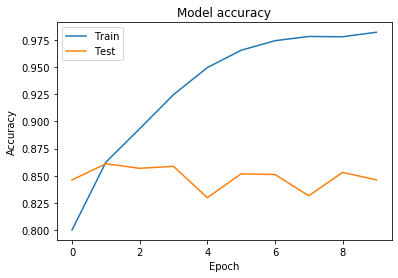

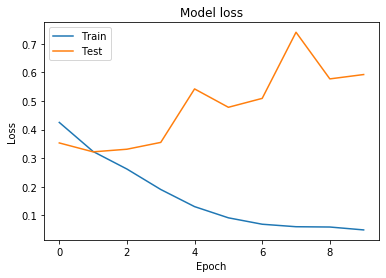

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [17]:
model.load_weights(output_dir+"/weights-improvement-02-0.86.hdf5")

In [18]:
y = model.predict_proba(x_valid)

(array([8992., 1569.,  976.,  779.,  767.,  783.,  807., 1096., 1759.,
        7472.]),
 array([0.00242552, 0.10197681, 0.2015281 , 0.3010794 , 0.40063068,
        0.500182  , 0.59973323, 0.69928455, 0.7988358 , 0.89838713,
        0.9979384 ], dtype=float32),
 <a list of 10 Patch objects>)

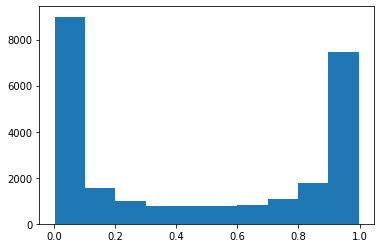

In [19]:
plt.hist(y)

In [20]:
score = model.evaluate(x_valid, y_valid, verbose=0)
print("Accuracy: %.2f%%" % (score[1]*100))

Accuracy: 86.10%


In [21]:
#area under curve score
"{:0.2f}".format(roc_auc_score(y_valid, y)*100)

'94.03'